$ Import \space all \space the \space required \space libraries$

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, TensorDataset,random_split


$Keypint \space using \space  MP \space  holistic$

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [5]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

c:\Users\pushp\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

$ Extract \space Keypoint \space Values$

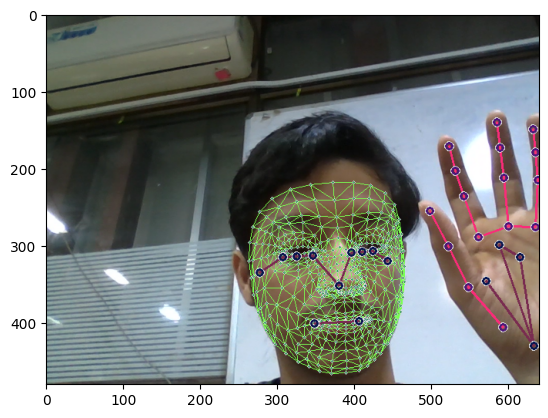

In [6]:
draw_landmarks(frame,results)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [7]:
print(len(results.face_landmarks.landmark))
print(len(results.left_hand_landmarks.landmark))
print(len(results.pose_landmarks.landmark))

468
21
33


In [9]:
def extract_points(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh])

In [10]:
result_test = extract_points(results)

In [11]:
# Save the results
np.save('0',result_test)
# Load the results
np.load('0.npy')

array([ 0.59414679,  0.73529238, -1.42063391, ...,  0.        ,
        0.        ,  0.        ])

$Setup \space folders \space for \space for \space collections$

In [12]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('ASL_TXT') 

# Actions that we try to detect
actions = np.array([chr(i) for i in range (ord('A'),ord('Z')+1)])

# 20 videos worth of data
no_sequences = 20

# Videos are going to be 20 frames in length
sequence_length = 20

In [13]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence)))
        except:
            pass

$Collect \space Keypoint \space Values \space for \space Training \space and \space Testing$

In [14]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions
    for action in actions:
        # Loop through sequences(videos)
        for sequence in range(no_sequences):
            # Loop through video length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_landmarks(image, results)
                
                #Applying wait logic for our comfort
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)                               
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                else: 
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)                               
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                #Export keypoints for these frames
                keypoints = extract_points(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [15]:
cap.release()
cv2.destroyAllWindows()

$Preprocessing \space data \space and \space create \space labels \space and \space features$

In [16]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
print(np.array(sequences).shape)
print(np.array(labels).shape)

(520, 20, 1662)
(520,)


$Trianing \space and \space build \space the \space dataset \space using \space LSTM \space Neural \space Network $

In [18]:
# Defining feature, output and Hyperparameters
input_size = 1662
hidden_size = 128
output_size = len(actions)
batch_size = 64
epochs = 1000

x = torch.tensor(sequences, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

C:\Users\pushp\AppData\Local\Temp\ipykernel_27632\4020917856.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  x = torch.tensor(sequences, dtype=torch.float32)


In [19]:
class ASL_LSTM_Model(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(ASL_LSTM_Model,self).__init__()
        self.lstm1 = nn.LSTM(input_size,hidden_size,batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size,hidden_size,batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size,hidden_size,batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, (hn, cn) = self.lstm3(x)         #hn here is final hidden states and cn is cell states
        x = self.relu(self.fc1(hn[-1]))     # hn[-1] refers to the hidden state of the last LSTM layer
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [20]:
# Create a dataset and dataloader
dataset = TensorDataset(x,y)
train_size = int(.95*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Initialize the model, loss function and optimizer
model = ASL_LSTM_Model(input_size,hidden_size,output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)

In [22]:
# Training Loops
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader)}')

Epoch [10/1000], Loss: 3.251823753118515
Epoch [20/1000], Loss: 3.2546567618846893


KeyboardInterrupt: 

In [143]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy: {100 * correct / total}%')

Accuracy: 3.0303030303030303%


$Tensorflow \space model \space check$

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [129]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(25,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

c:\Users\pushp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [130]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [135]:
model.fit(x, y, epochs=2000)

Epoch 1/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - categorical_accuracy: 0.0496 - loss: 3.4953
Epoch 2/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - categorical_accuracy: 0.0546 - loss: 3.2811
Epoch 3/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - categorical_accuracy: 0.0730 - loss: 3.2473
Epoch 4/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - categorical_accuracy: 0.0340 - loss: 3.2401
Epoch 5/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - categorical_accuracy: 0.0467 - loss: 3.2040
Epoch 6/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - categorical_accuracy: 0.0686 - loss: 3.2300
Epoch 7/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - categorical_accuracy: 0.0399 - loss: 3.1989
Epoch 8/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - categorical_accuracy: 0.0544 - loss: 3.1672
Epoch 9/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - categorical_accuracy: 0.0417 - loss: 3.2475
Epoch 10/2000
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - categorical_accuracy: 0.0461 - loss: 3.2494
Epoch 11/

KeyboardInterrupt: 

In [134]:
from tensorflow.keras.utils import to_categorical
X = np.array(sequences)
(90, 30, 1662)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [145]:
# This is to check some changes are working or not
class ASL_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ASL_LSTM_Model, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.2)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.relu(self.fc1(x[:, -1, :]))  # Use the last time-step output for classification
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x


$Increased LSTM check$

In [149]:
class ASL_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ASL_LSTM_Model, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.2)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.2)
        self.lstm4 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.2)  # Additional LSTM layer
        self.lstm5 = nn.LSTM(hidden_size, hidden_size, batch_first=True, dropout=0.2)  # Additional LSTM layer
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)  # Additional LSTM layer
        x, _ = self.lstm5(x)  # Additional LSTM layer
        x = self.relu(self.fc1(x[:, -1, :]))  # Use the output from the last timestep
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x


In [150]:
# Training Loops
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader)}')

Epoch [10/1000], Loss: 3.0888563871383665
Epoch [20/1000], Loss: 3.050572633743286
Epoch [30/1000], Loss: 3.000214433670044
Epoch [40/1000], Loss: 2.9970752716064455
Epoch [50/1000], Loss: 3.0199229240417482
Epoch [60/1000], Loss: 3.00135178565979
Epoch [70/1000], Loss: 3.0188557624816896
Epoch [80/1000], Loss: 3.0063127279281616
Epoch [90/1000], Loss: 3.0060367822647094
Epoch [100/1000], Loss: 2.9992717266082765
Epoch [110/1000], Loss: 3.003764009475708
Epoch [120/1000], Loss: 3.0470347881317137
Epoch [130/1000], Loss: 2.9899325370788574
Epoch [140/1000], Loss: 2.9873572826385497
Epoch [150/1000], Loss: 2.960125732421875
Epoch [160/1000], Loss: 3.015363669395447
Epoch [170/1000], Loss: 3.030269432067871
Epoch [180/1000], Loss: 2.994852662086487
Epoch [190/1000], Loss: 2.973100018501282
Epoch [200/1000], Loss: 2.9846764087677
Epoch [210/1000], Loss: 2.9539559841156007
Epoch [220/1000], Loss: 2.9681161880493163
Epoch [230/1000], Loss: 2.9716938734054565
Epoch [240/1000], Loss: 2.9952031

KeyboardInterrupt: 

In [151]:
# Define LSTM model
class ASL_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ASL_LSTM_Model, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm4 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm5 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm6 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm7 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm8 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm9 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm10 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x, _ = self.lstm7(x)
        x, _ = self.lstm8(x)
        x, _ = self.lstm9(x)
        x, _ = self.lstm10(x)
        x = self.relu(self.fc1(x[:, -1, :]))  # Use the output from the last time step
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.softmax(x)
        return x

# Initialize model, loss function, and optimizer
model = ASL_LSTM_Model(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [152]:
# Training Loops
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader)}')

Epoch [10/1000], Loss: 3.257984471321106
Epoch [20/1000], Loss: 3.2577759504318236
Epoch [30/1000], Loss: 3.2574583292007446
Epoch [40/1000], Loss: 3.2572514533996584
Epoch [50/1000], Loss: 3.257149887084961
Epoch [60/1000], Loss: 3.2576157569885256


KeyboardInterrupt: 

$ Considering \space the \space left \space and \space right \space hands \space only$

In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Initialize Mediapipe Holistic model and drawing utilities
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

def extract_hand_points(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('ASL_TXT')

# Actions that we try to detect
actions = np.array([chr(i) for i in range(ord('A'), ord('Z') + 1)])

# 20 videos worth of data
no_sequences = 20

# Videos are going to be 20 frames in length
sequence_length = 20

# Create directories for data
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_landmarks(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)                               
                    cv2.imshow('OpenCV Feed', image)
                else: 
                    cv2.putText(image, f'Collecting frames for {action} Video Number {sequence}', (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)                               
                    cv2.imshow('OpenCV Feed', image)
                
                keypoints = extract_hand_points(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
cap.release()
cv2.destroyAllWindows()


In [27]:
label_map = {label:num for num, label in enumerate(actions)}
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# Convert data to tensors
x = torch.tensor(sequences, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

# Dataset and DataLoader
dataset = TensorDataset(x, y)
train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [28]:
class ASL_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ASL_LSTM_Model, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, (hn, cn) = self.lstm3(x)
        x = self.relu(self.fc1(hn[-1]))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Initialize the model, loss function, and optimizer
model = ASL_LSTM_Model(input_size=126, hidden_size=128, output_size=len(actions))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader)}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Epoch [10/1000], Loss: 3.2052991688251495
Epoch [20/1000], Loss: 3.1720075607299805
Epoch [30/1000], Loss: 3.1697482466697693
Epoch [40/1000], Loss: 3.133990556001663
Epoch [50/1000], Loss: 3.092955470085144
Epoch [60/1000], Loss: 3.0992795526981354
Epoch [70/1000], Loss: 3.177862763404846
Epoch [80/1000], Loss: 3.2407544553279877
Epoch [90/1000], Loss: 3.2336750626564026
Epoch [100/1000], Loss: 3.2298655807971954
Epoch [110/1000], Loss: 3.1611203849315643
Epoch [120/1000], Loss: 3.146053373813629
Epoch [130/1000], Loss: 3.085362285375595
Epoch [140/1000], Loss: 3.118014335632324
Epoch [150/1000], Loss: 3.04946830868721
Epoch [160/1000], Loss: 3.0231554210186005
Epoch [170/1000], Loss: 2.9652809500694275
Epoch [180/1000], Loss: 3.2828468084335327
Epoch [190/1000], Loss: 3.251004785299301
Epoch [200/1000], Loss: 3.2452197670936584
Epoch [210/1000], Loss: 3.2413314282894135
Epoch [220/1000], Loss: 3.2413960993289948
Epoch [230/1000], Loss: 3.2426839768886566
Epoch [240/1000], Loss: 3.241

In [25]:
# Deleting previous stored data of training
import shutil
import os

# Path for the recorded data
DATA_PATH = os.path.join('ASL_TXT')

def delete_data(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        print(f"Deleted data at {path}")
    else:
        print(f"No data found at {path}")

# Delete the previous data
delete_data(DATA_PATH)

# Recreate the directories if needed for new data collection
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except Exception as e:
            print(f"Error creating directory {e}")


Deleted data at ASL_TXT
